In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gym
import stable_baselines
from stable_baselines import A2C, ACER, ACKTR, DQN, DDPG, SAC, PPO1, PPO2, TD3, TRPO
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.gail import ExpertDataset, generate_expert_traj

from fakegym.fakegym import FakeGym
import importlib

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [67]:
def exponential_decay(x, N0=1, lambda_=5):
    return N0*np.exp(-lambda_*x)

def exponential_penalty(x, step_penalty=-1, lambda_=5):
    return step_penalty * (1 - exponential_decay(x, lambda_=lambda_))

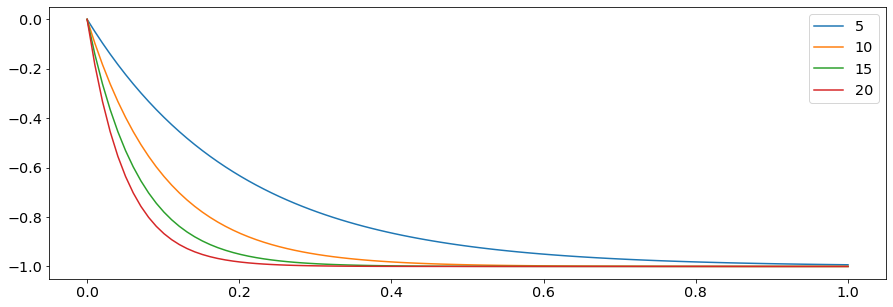

In [75]:
x = np.linspace(0, 1, 100)
for l in [5,10,15,20]:
    y = exponential_penalty(x, lambda_=l)
    plt.plot(x, y, label=str(l))
plt.legend()

In [74]:
class MyObservation():
    def __init__(self, env, num_sensors=4):
        self.env = env
        self.num_sensors = num_sensors
        self.gps_actual = None
        self.gps_target = None
        self.distance = None
        self.touching = None

    def _update(self):
        self.gps_actual = self.env.state_object.gps_actual
        self.gps_target = self.env.state_object.gps_target
        self.distance = self.env.state_object.distance
        self.touching = self.env.state_object.touching

    def shape(self):
        return (self.num_sensors + 5, )

    def get(self, env):
        """Get observation as numpy array."""
        self._update()
        
        arr = np.empty(0)
        arr = np.hstack((arr, np.array(self.gps_actual)))
        arr = np.hstack((arr, np.array(self.gps_target)))
        arr = np.hstack((arr, np.array(self.distance)))
        arr = np.hstack((arr, np.array(self.touching)))
        
        return arr

class MyEnv(FakeGym):
    def __init__(self, seed=None, N=10, num_of_sensors=4, obs_len=1, obstacles_each=4,
                 step_range=(1, 1), action_type="discrete",
                 discrete_action_shaping="flatten", obs=MyObservation):
        obs = MyObservation(self, num_of_sensors)
        super(MyEnv, self).__init__(seed, N, num_of_sensors, obstacles_each, step_range, action_type, discrete_action_shaping, obs, obs_len=obs_len)
        
    def calc_reward(self):
        if self.gps_actual == self.gps_target:
            reward = 1000
        else:
            distance_normalized = self.get_target_distance(normalized=True)
            step_base_penalty = -1
            reward = exponential_penalty(x=distance_normalized, step_penalty=step_base_penalty, lambda_=5)
            if self.state_object.touching is True:
                reward -= 100
        return reward
        
        
    def check_done(self):
        if self.com.time_steps == 1000:
            return True
        if self.total_reward < -1000:
            return True
        if self.gps_actual == self.gps_target:
            return True
        return False


env = MyEnv(N=10, num_of_sensors=4, obs_len=1, obstacles_each=4)
check_env(env)

In [12]:
time_steps = 4*10**4
model_name = "PPO_40k_4sensors_N=10_obs=3x1"
model = PPO1("MlpPolicy", env)
model.learn(total_timesteps=time_steps)
model.save("../models/fake/{}".format(model_name))





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
def predict(env, seed, model, steps=100, render=False, return_val=222):
    obs = env.reset(seed)
    for i in range(steps):
        if render is True:
            env.render()
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done is True:
            return i
    return return_val

In [61]:
# CHANGE HERE ONLY
# env settings
N = 12
obs_len = 3
obstacles_each = 4

# model loading
model1 = PPO1.load("../models/fake/{}".format("PPO_40k_4sensors_N=10_obs=3x1"))
model2 = PPO1.load("../models/fake/{}".format("PPO_80k_4sensors_N=10_obs=3x1"))
model3 = PPO1.load("../models/fake/{}".format("PPO_120k_4sensors_N=10_obs=3x1"))
models = [model1, model2, model3]
sensors = [4, 4, 4]
names = ["40k", "80k", "120k"]
models_d = dict(zip(models, sensors))

# run simulations
res_all = np.empty((0, len(models)))
num_of_steps = 200
num_of_envs = 100
for env_seed in range(num_of_envs):
    res_env = np.empty(len(models))
    for model_idx, model in enumerate(list(models_d.keys())):
        num_sensors = models_d[model]
        env = MyEnv(N=N, obs_len=obs_len, obstacles_each=obstacles_each, num_of_sensors=num_sensors)
        res_env[model_idx] = predict(env, env_seed, model, num_of_steps)
    res_all = np.vstack((res_all, res_env))
    
df = pd.DataFrame(res_all)
df.columns = names

/home/pj/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [62]:
df_analysis = df.copy()
df_analysis["all"] = df_analysis.sum(axis=1)
df_analysis["seed"] = range(num_of_envs)
df_analysis.sort_values("all", ascending=False)

,40k,80k,120k,all,seed
25,65.0,47.0,50.0,162.0,25
80,21.0,42.0,98.0,161.0,80
32,34.0,63.0,63.0,160.0,32
11,46.0,84.0,14.0,144.0,11
90,19.0,44.0,79.0,142.0,90
...,...,...,...,...,...
43,3.0,2.0,0.0,5.0,43
91,2.0,1.0,1.0,4.0,91
15,1.0,1.0,1.0,3.0,15
95,0.0,0.0,2.0,2.0,95


In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

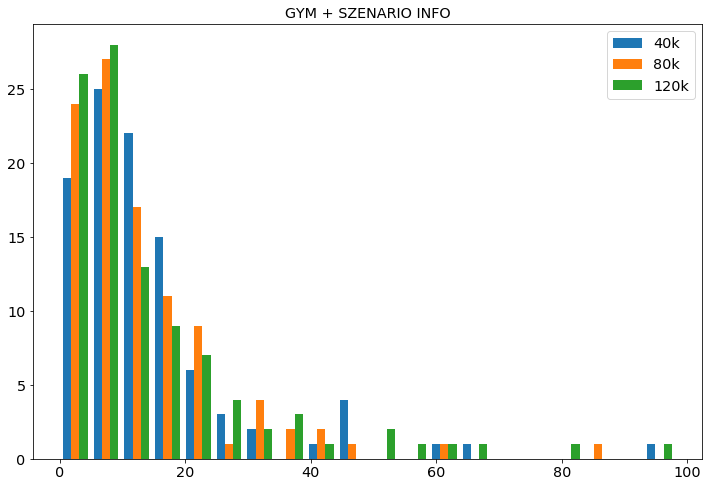

In [66]:
plt.figure(figsize=(12,8))
plt.hist(df.values, 20, histtype='bar', label=names)
plt.title('GYM + SZENARIO INFO')
plt.legend()
plt.show()